In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from PIL import Image
import numpy as np

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)

torch.manual_seed(42)

# Variational Autoencoders (VAE)

<span style="font-size: 15px;">

In the previous notebook (`Latent_Variable_Models_and_Autoencoders.ipynb`), we introduced the standard autoencoder, a neural network that learns compressed representations of data through an encoder-decoder architecture. While autoencoders are powerful for dimensionality reduction and feature learning, they have a fundamental limitation: **they are not true generative models**.

The problem lies in the latent space structure. In a standard autoencoder:
- The encoder maps each input $x$ to a **deterministic** point $z$ in latent space
- The latent space has "holes", regions where no training data maps to
- Sampling random vectors from the latent space often produces meaningless outputs

The **Variational Autoencoder (VAE)**, introduced by Kingma and Welling (2014), addresses these limitations by introducing **probability** and **stochasticity** into the autoencoder framework, **transforming** it into a proper generative model.

</span>

## The Natural Image Manifold and Latent Representations

<span style="font-size: 15px;">

Before diving into the VAE architecture, let's build intuition about what we're trying to learn.

**The Pixel Space $\mathcal{X}$**

Consider the space of all possible images. For a $28 \times 28$ grayscale image, this is $\mathcal{X} = [0, 1]^{784}$, a 784-dimensional hypercube. However, not all points in this space correspond to "natural" or meaningful images. Random noise is technically a valid point in pixel space, but it doesn't represent anything recognizable.

**The Natural Image Manifold**

Real-world images (faces, digits, cats, etc.) occupy only a tiny subspace of the full pixel space. This subspace is often called the **natural image manifold**,a complex, high-dimensional surface where:
- Similar images are close together (cats near cats, dogs near dogs)
- The manifold captures the underlying structure that makes images "natural"

**The Latent Space $\mathcal{Z}$**

The goal of generative models is to learn a **latent space** $\mathcal{Z}$ that:
1. Is lower-dimensional than pixel space ($D_z \ll D_x$)
2. Captures the essential features of the data ("two eyes," "four legs," "curved stroke")
3. Is **smooth** and **continuous**, nearby points produce similar outputs
4. Can be easily sampled from for generation

A well-trained VAE learns a latent space where:
$$
\text{Simple distribution in } \mathcal{Z} \xrightarrow{\text{Decoder}} \text{Complex distribution in } \mathcal{X}
$$

</span>

## From Autoencoder to Variational Autoencoder

<span style="font-size: 15px;">

**The Limitation of Deterministic Autoencoders**

Recall that a standard autoencoder performs the following mapping:
$$
x \xrightarrow{E_\phi} z \xrightarrow{D_\theta} \hat{x}
$$

where the encoder $E_\phi$ maps each input to a **single, fixed point** in latent space. This deterministic mapping means:
- The same input always produces the same latent vector
- The latent space has no inherent structure, points are scattered wherever minimizes reconstruction error
- We cannot meaningfully sample from the latent space

**The VAE Solution: Probabilistic Encoding**

The key insight of the VAE is to replace the deterministic encoder with a **probabilistic** one:

$$
\boxed{
\text{Autoencoder: } x \to z \quad \text{vs} \quad \text{VAE: } x \to p(z|x) = \mathcal{N}(\mu, \sigma^2)
}
$$

Instead of encoding to a point, the VAE encoder outputs the **parameters of a probability distribution**:
- A mean vector $\mu \in \mathbb{R}^{D_z}$
- A variance vector $\sigma^2 \in \mathbb{R}^{D_z}$ (or equivalently, log-variance $\log \sigma^2$)

The latent vector $z$ is then **sampled** from this distribution:
$$
z \sim \mathcal{N}(\mu, \text{diag}(\sigma^2))
$$

This simple change has profound consequences:
1. **Stochasticity**: The same input can produce different latent vectors (and thus different reconstructions)
2. **Structured latent space**: The latent space is regularized to approximate a known distribution
3. **Generative capability**: We can sample $z \sim \mathcal{N}(0, I)$ and decode to generate new images

</span>

## Mathematical Framework of VAEs

**The Generative Model**

<span style="font-size: 15px;">

The VAE assumes the following generative process for data:

1. Sample a latent variable from a **prior** distribution:
   $$z \sim p(z) = \mathcal{N}(0, I)$$

2. Generate data from a **conditional likelihood**:
   $$x \sim p_\theta(x|z)$$

where $\theta$ are the parameters of the decoder network. The decoder defines $p_\theta(x|z)$, which for continuous data is often a Gaussian with mean given by the decoder output.

**The Inference Problem**

Given observed data $x$, we want to infer the latent variable $z$ that generated it. By Bayes' theorem:

$$
p(z|x) = \frac{p_\theta(x|z) \, p(z)}{p(x)}
$$

However, the **evidence** $p(x) = \int p_\theta(x|z) \, p(z) \, dz$ is intractable, it requires integrating over all possible latent vectors.

**Variational Inference**

Since we cannot compute $p(z|x)$ exactly, we **approximate** it with a simpler distribution $q_\phi(z|x)$ parameterized by the encoder network:

$$
q_\phi(z|x) = \mathcal{N}(z; \mu_\phi(x), \text{diag}(\sigma^2_\phi(x)))
$$

The encoder neural network outputs $\mu_\phi(x)$ and $\sigma^2_\phi(x)$ (or $\log \sigma^2_\phi(x)$) for each input $x$.

**Goal**: Find parameters $\phi$ such that $q_\phi(z|x)$ is close to the true posterior $p(z|x)$.

</span>


### The KL Divergence

<span style="font-size: 15px;">

To measure how close $q_\phi(z|x)$ is to $p(z|x)$, we use the **Kullback-Leibler (KL) divergence**:

$$
D_{\text{KL}}(q \| p) = \mathbb{E}_{z \sim q}\left[ \log \frac{q(z)}{p(z)} \right] = \int q(z) \log \frac{q(z)}{p(z)} \, dz
$$

**Key properties of KL divergence:**

1. $D_{\text{KL}}(q \| p) \geq 0$ always (non-negative)
2. $D_{\text{KL}}(q \| p) = 0$ if and only if $q = p$ almost everywhere
3. **Asymmetric**: $D_{\text{KL}}(q \| p) \neq D_{\text{KL}}(p \| q)$ in general

The KL divergence can be interpreted as:
- The expected **extra bits** needed to encode samples from $q$ using a code optimized for $p$
- A measure of **information loss** when using $q$ to approximate $p$

**Intuition**: If $q$ and $p$ are both Gaussians, $D_{\text{KL}}(q \| p)$ penalizes differences in both mean and variance.

</span>

### The Evidence Lower Bound (ELBO)

<span style="font-size: 15px;">

We want to maximize the log-likelihood of our data $\log p(x)$. Through a derivation involving Jensen's inequality, we can show:

$$
\log p(x) = \underbrace{\mathbb{E}_{z \sim q_\phi(z|x)}\left[ \log p_\theta(x|z) \right]}_{\text{Reconstruction term}} - \underbrace{D_{\text{KL}}(q_\phi(z|x) \| p(z))}_{\text{Regularization term}} + \underbrace{D_{\text{KL}}(q_\phi(z|x) \| p(z|x))}_{\geq 0}
$$

Since $D_{\text{KL}}(q_\phi(z|x) \| p(z|x)) \geq 0$, we have:

$$
\log p(x) \geq \underbrace{\mathbb{E}_{z \sim q_\phi(z|x)}\left[ \log p_\theta(x|z) \right] - D_{\text{KL}}(q_\phi(z|x) \| p(z))}_{\text{ELBO}(x; \phi, \theta)}
$$

This lower bound is called the **Evidence Lower Bound (ELBO)**. Maximizing the ELBO simultaneously:
1. Maximizes the data likelihood (generative quality)
2. Minimizes $D_{\text{KL}}(q_\phi(z|x) \| p(z|x))$ (inference quality)

</span>

### The VAE Loss Function

<span style="font-size: 15px;">

The VAE is trained by **maximizing the ELBO**, or equivalently, **minimizing the negative ELBO**:

$$
\mathcal{L}_{\text{VAE}}(x; \phi, \theta) = -\text{ELBO} = \underbrace{-\mathbb{E}_{z \sim q_\phi(z|x)}\left[ \log p_\theta(x|z) \right]}_{\mathcal{L}_{\text{recon}}} + \underbrace{D_{\text{KL}}(q_\phi(z|x) \| p(z))}_{\mathcal{L}_{\text{KL}}}
$$

**Reconstruction Loss $\mathcal{L}_{\text{recon}}$**:
- Measures how well the decoder reconstructs the input from sampled latent vectors
- For Gaussian $p_\theta(x|z)$ with fixed variance: equivalent to MSE loss
- For Bernoulli $p_\theta(x|z)$ (binary images): equivalent to BCE loss

**KL Divergence Loss $\mathcal{L}_{\text{KL}}$**:
- Regularizes the encoder to produce distributions close to the prior $p(z) = \mathcal{N}(0, I)$
- Prevents the encoder from collapsing to deterministic mappings
- Ensures the latent space is smooth and continuous

**Closed-form KL for Gaussians**:

When $q_\phi(z|x) = \mathcal{N}(\mu, \text{diag}(\sigma^2))$ and $p(z) = \mathcal{N}(0, I)$, the KL divergence has a closed form:

$$
D_{\text{KL}}(q_\phi(z|x) \| p(z)) = -\frac{1}{2} \sum_{j=1}^{D_z} \left( 1 + \log \sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)
$$

Or equivalently, using log-variance $\gamma_j = \log \sigma_j^2$:

$$
D_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{D_z} \left( 1 + \gamma_j - \mu_j^2 - e^{\gamma_j} \right)
$$

</span>

### The Reparameterization Trick

<span style="font-size: 15px;">

There's a problem: we need to backpropagate through the sampling operation $z \sim q_\phi(z|x)$, but sampling is **non-differentiable**.

**The Solution: Reparameterization**

Instead of sampling $z$ directly from $\mathcal{N}(\mu, \sigma^2)$, we reparameterize as:

$$
z = \mu + \sigma \odot \epsilon, \quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$

Here $\odot$ denotes element-wise multiplication.

**Why this works:**
- The randomness is now in $\epsilon$, which doesn't depend on any parameters
- $z$ is a deterministic function of $\mu$, $\sigma$, and $\epsilon$
- Gradients can flow through $\mu$ and $\sigma$ to the encoder

**In PyTorch:**
```python
def reparameterize(self, mu, logvar):
    std = torch.exp(0.5 * logvar)  # σ = exp(0.5 * log(σ²))
    eps = torch.randn_like(std)     # ε ~ N(0, I)
    return mu + eps * std           # z = μ + ε ⊙ σ
```

</span>

## VAE Architecture Summary

<span style="font-size: 15px;">

The complete VAE architecture can be summarized as:

$$
\boxed{
x \xrightarrow{\text{Encoder}} (\mu, \log\sigma^2) \xrightarrow{\text{Reparameterize}} z = \mu + \sigma \odot \epsilon \xrightarrow{\text{Decoder}} \hat{x}
}
$$

**Components:**

| Component | Input | Output | Function |
|-----------|-------|--------|----------|
| Encoder $E_\phi$ | $x \in \mathbb{R}^{D_x}$ | $\mu, \log\sigma^2 \in \mathbb{R}^{D_z}$ | Learn approximate posterior |
| Reparameterization | $\mu, \sigma, \epsilon$ | $z \in \mathbb{R}^{D_z}$ | Enable backpropagation |
| Decoder $D_\theta$ | $z \in \mathbb{R}^{D_z}$ | $\hat{x} \in \mathbb{R}^{D_x}$ | Generate reconstruction |

**Training:**
$$
\mathcal{L}_{\text{VAE}} = \underbrace{\|x - \hat{x}\|^2}_{\text{Reconstruction}} + \underbrace{\beta \cdot D_{\text{KL}}(q_\phi(z|x) \| p(z))}_{\text{Regularization}}
$$

where $\beta$ is a hyperparameter (often $\beta = 1$, but $\beta$-VAE uses different values).

**Generation:**
$$
z \sim \mathcal{N}(0, I) \xrightarrow{D_\theta} \hat{x}_{\text{new}}
$$

</span>

## VAE Implementation in PyTorch

<span style="font-size: 15px;">

We now implement a convolutional VAE in PyTorch. The architecture uses:
- **Encoder**: Convolutional layers to extract features, then linear layers to output $\mu$ and $\log\sigma^2$
- **Decoder**: Linear layer followed by transposed convolutions to reconstruct the image

We'll design this for 28×28 grayscale images (MNIST/Fashion-MNIST).

</span>

### Building the VAE

In [3]:
class VAE(nn.Module):
    """
    Convolutional Variational Autoencoder.
    
    Architecture for 28x28 input:
        Encoder: (1, 28, 28) -> Conv layers -> Flatten -> (μ, log σ²)
        Decoder: z -> FC -> Unflatten -> ConvTranspose layers -> (1, 28, 28)
    
    The encoder outputs parameters of q(z|x) = N(μ, σ²I)
    The decoder defines p(x|z)
    """
    
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        
        self.latent_dim = latent_dim
        
        # ============ Encoder ============
        # Convolutional layers: (1, 28, 28) -> (32, 4, 4)
        self.encoder = nn.Sequential(
            # (1, 28, 28) -> (8, 14, 14)
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # (8, 14, 14) -> (16, 7, 7)
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # (16, 7, 7) -> (32, 4, 4)  (note: 7->4 with stride=2, padding=1)
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # Flatten: (32, 4, 4) -> (512,)
            nn.Flatten()
        )
        
        # Latent space projections
        # The flattened encoder output has size 32 * 4 * 4 = 512
        self.fc_mu = nn.Linear(512, latent_dim)      # μ
        self.fc_logvar = nn.Linear(512, latent_dim)  # log(σ²)
        
        # ============ Decoder ============
        # Project from latent space back to feature maps
        self.fc_decode = nn.Linear(latent_dim, 512)
        
        # Transposed convolutions: (32, 4, 4) -> (1, 28, 28)
        self.decoder = nn.Sequential(
            # Unflatten: (512,) -> (32, 4, 4)
            nn.Unflatten(1, (32, 4, 4)),
            # (32, 4, 4) -> (16, 7, 7)
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            # (16, 7, 7) -> (8, 14, 14)
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            # (8, 14, 14) -> (1, 28, 28)
            nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in [0, 1] for pixel values
        )
    
    def encode(self, x):
        """
        Encode input to distribution parameters.
        
        Args:
            x: Input tensor of shape (B, 1, 28, 28)
        
        Returns:
            mu: Mean of q(z|x), shape (B, latent_dim)
            logvar: Log-variance of q(z|x), shape (B, latent_dim)
        """
        h = self.encoder(x)  # (B, 512)
        mu = self.fc_mu(h)        # (B, latent_dim)
        logvar = self.fc_logvar(h)  # (B, latent_dim)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick: z = μ + σ ⊙ ε, where ε ~ N(0, I)
        
        This allows backpropagation through the sampling operation.
        
        Args:
            mu: Mean of the latent distribution (B, latent_dim)
            logvar: Log-variance of the latent distribution (B, latent_dim)
        
        Returns:
            z: Sampled latent vector (B, latent_dim)
        """
        # Compute standard deviation: σ = exp(0.5 * log(σ²))
        std = torch.exp(0.5 * logvar)
        
        # Sample ε ~ N(0, I)
        eps = torch.randn_like(std)
        
        # z = μ + ε ⊙ σ
        return mu + eps * std
    
    def decode(self, z):
        """
        Decode latent vector to reconstruction.
        
        Args:
            z: Latent vector of shape (B, latent_dim)
        
        Returns:
            x_hat: Reconstructed image of shape (B, 1, 28, 28)
        """
        h = self.fc_decode(z)  # (B, 512)
        return self.decoder(h)  # (B, 1, 28, 28)
    
    def forward(self, x):
        """
        Full forward pass: encode -> reparameterize -> decode
        
        Args:
            x: Input tensor of shape (B, 1, 28, 28)
        
        Returns:
            x_hat: Reconstruction of shape (B, 1, 28, 28)
            mu: Mean of q(z|x) for KL computation
            logvar: Log-variance of q(z|x) for KL computation
        """
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

In [4]:
# Verify the architecture
latent_dim = 32
vae = VAE(latent_dim=latent_dim)

print("VAE Architecture")
print("=" * 60)
print(f"Latent dimension: D_z = {latent_dim}")
print()
print("Encoder (convolutional):")
print(vae.encoder)
print()
print("Latent projections:")
print(f"  μ projection:      {vae.fc_mu}")
print(f"  log(σ²) projection: {vae.fc_logvar}")
print()
print("Decoder (transposed convolutional):")
print(vae.decoder)

VAE Architecture
Latent dimension: D_z = 32

Encoder (convolutional):
Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
)

Latent projections:
  μ projection:      Linear(in_features=512, out_features=32, bias=True)
  log(σ²) projection: Linear(in_features=512, out_features=32, bias=True)

Decoder (transposed convolutional):
Sequential(
  (0): Unflatten(dim=1, unflattened_size=(32, 4, 4))
  (1): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (2): ReLU()
  (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (4): ReLU()
  (5): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (6): Sigmoid()
)


In [5]:
# Count parameters
def count_parameters(module):
    return sum(p.numel() for p in module.parameters() if p.requires_grad)

encoder_params = count_parameters(vae.encoder) + count_parameters(vae.fc_mu) + count_parameters(vae.fc_logvar)
decoder_params = count_parameters(vae.fc_decode) + count_parameters(vae.decoder)
total_params = count_parameters(vae)

print("\nParameter Count")
print("=" * 60)
print(f"Encoder parameters: {encoder_params:,}")
print(f"Decoder parameters: {decoder_params:,}")
print(f"Total parameters:   {total_params:,}")


Parameter Count
Encoder parameters: 38,720
Decoder parameters: 22,753
Total parameters:   61,473


In [6]:
# Test forward pass
batch_size = 16
x = torch.randn(batch_size, 1, 28, 28)

# Forward pass
x_hat, mu, logvar = vae(x)

print("Forward Pass Verification")
print("=" * 60)
print(f"Input shape:       x.shape = {tuple(x.shape)} → (B, C, H, W)")
print(f"Mean shape:        μ.shape = {tuple(mu.shape)} → (B, D_z)")
print(f"Log-var shape:     log(σ²).shape = {tuple(logvar.shape)} → (B, D_z)")
print(f"Output shape:      x̂.shape = {tuple(x_hat.shape)} → (B, C, H, W)")
print()
print(f"Output range: [{x_hat.min().item():.4f}, {x_hat.max().item():.4f}] (should be in [0, 1])")

Forward Pass Verification
Input shape:       x.shape = (16, 1, 28, 28) → (B, C, H, W)
Mean shape:        μ.shape = (16, 32) → (B, D_z)
Log-var shape:     log(σ²).shape = (16, 32) → (B, D_z)
Output shape:      x̂.shape = (16, 1, 28, 28) → (B, C, H, W)

Output range: [0.5010, 0.6379] (should be in [0, 1])


In [7]:
# Verify reparameterization produces different samples
mu_test = torch.zeros(1, latent_dim)
logvar_test = torch.zeros(1, latent_dim)  # σ² = 1

print("Reparameterization Verification")
print("=" * 60)
print("Sampling 5 latent vectors from N(0, I):")
for i in range(5):
    z = vae.reparameterize(mu_test, logvar_test)
    print(f"  Sample {i+1}: mean={z.mean().item():.4f}, std={z.std().item():.4f}")
print("\n(Each sample is different due to stochastic ε)")

Reparameterization Verification
Sampling 5 latent vectors from N(0, I):
  Sample 1: mean=-0.1854, std=0.7435
  Sample 2: mean=-0.1711, std=1.0524
  Sample 3: mean=-0.1126, std=0.8329
  Sample 4: mean=-0.0017, std=0.7766
  Sample 5: mean=0.2767, std=1.2376

(Each sample is different due to stochastic ε)


### The VAE Loss Function

<span style="font-size: 15px;">

The VAE loss consists of two terms:

$$
\mathcal{L}_{\text{VAE}} = \mathcal{L}_{\text{recon}} + \beta \cdot \mathcal{L}_{\text{KL}}
$$

**1. Reconstruction Loss:**
$$
\mathcal{L}_{\text{recon}} = \frac{1}{N} \sum_{b=1}^{N} \| x^{(b)} - \hat{x}^{(b)} \|^2
$$

**2. KL Divergence Loss:**
$$
\mathcal{L}_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{D_z} \left( 1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)
$$

Let's implement this:

</span>

In [9]:
def vae_loss(x, x_hat, mu, logvar, beta=1.0):
    """
    Compute the VAE loss = Reconstruction Loss + β * KL Divergence
    
    Args:
        x: Original input (B, C, H, W)
        x_hat: Reconstruction (B, C, H, W)
        mu: Mean of q(z|x) (B, D_z)
        logvar: Log-variance of q(z|x) (B, D_z)
        beta: Weight for KL term (default=1.0)
    
    Returns:
        total_loss: Combined VAE loss
        recon_loss: Reconstruction component
        kl_loss: KL divergence component
    """
    # Reconstruction loss: MSE
    # Sum over all dimensions (C, H, W), average over batch
    recon_loss = F.mse_loss(x_hat, x, reduction='sum') / x.size(0)
    
    # KL Divergence: -0.5 * Σ(1 + log(σ²) - μ² - σ²)
    # Sum over latent dimensions, average over batch
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    
    # Total loss
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

In [10]:
# Verify loss computation
x = torch.rand(16, 1, 28, 28)  # Random "images"
x_hat, mu, logvar = vae(x)

total_loss, recon_loss, kl_loss = vae_loss(x, x_hat, mu, logvar)

print("Loss Computation Verification")
print("=" * 60)
print(f"Reconstruction Loss: {recon_loss.item():.4f}")
print(f"KL Divergence Loss:  {kl_loss.item():.4f}")
print(f"Total VAE Loss:      {total_loss.item():.4f}")
print()
print("Note: Untrained model, so losses are high and unbalanced.")

Loss Computation Verification
Reconstruction Loss: 67.2346
KL Divergence Loss:  0.0314
Total VAE Loss:      67.2660

Note: Untrained model, so losses are high and unbalanced.


<span style="font-size: 15px;">

**Understanding the KL Loss:**

Let's verify our KL divergence formula is correct by computing it manually:

</span>

In [11]:
# Manual verification of KL divergence
# For q = N(μ, σ²) and p = N(0, 1):
# KL(q || p) = -0.5 * (1 + log(σ²) - μ² - σ²)

# Test with known values
mu_test = torch.tensor([[1.0, 0.0]])  # Mean shifted by 1 in first dim
logvar_test = torch.tensor([[0.0, 0.0]])  # σ² = 1

# Compute KL
kl_manual = -0.5 * torch.sum(1 + logvar_test - mu_test.pow(2) - logvar_test.exp())

print("KL Divergence Manual Verification")
print("=" * 60)
print(f"μ = {mu_test.numpy()}")
print(f"σ² = {logvar_test.exp().numpy()}")
print(f"")
print(f"For dimension 1 (μ=1, σ²=1):")
print(f"  KL = -0.5 * (1 + log(1) - 1² - 1) = -0.5 * (1 + 0 - 1 - 1) = 0.5")
print(f"For dimension 2 (μ=0, σ²=1):")
print(f"  KL = -0.5 * (1 + log(1) - 0² - 1) = -0.5 * (1 + 0 - 0 - 1) = 0")
print(f"")
print(f"Total KL (computed): {kl_manual.item():.4f}")
print(f"Expected: 0.5 + 0 = 0.5")

KL Divergence Manual Verification
μ = [[1. 0.]]
σ² = [[1. 1.]]

For dimension 1 (μ=1, σ²=1):
  KL = -0.5 * (1 + log(1) - 1² - 1) = -0.5 * (1 + 0 - 1 - 1) = 0.5
For dimension 2 (μ=0, σ²=1):
  KL = -0.5 * (1 + log(1) - 0² - 1) = -0.5 * (1 + 0 - 0 - 1) = 0

Total KL (computed): 0.5000
Expected: 0.5 + 0 = 0.5


### Comparison: Autoencoder vs VAE

<span style="font-size: 15px;">

| Aspect | Autoencoder | VAE |
|--------|-------------|-----|
| **Encoding** | Deterministic: $z = E_\phi(x)$ | Probabilistic: $q_\phi(z|x) = \mathcal{N}(\mu, \sigma^2)$ |
| **Latent Space** | Unstructured | Regularized to $\approx \mathcal{N}(0, I)$ |
| **Loss Function** | $\mathcal{L} = \|x - \hat{x}\|^2$ | $\mathcal{L} = \|x - \hat{x}\|^2 + D_{\text{KL}}$ |
| **Generation** | Poor (holes in latent space) | Good (smooth, structured latent space) |
| **Same Input** | Always same $z$ | Different $z$ each time (stochastic) |
| **Use Case** | Compression, feature extraction | Generation, interpolation |

</span>

### Summary

<span style="font-size: 15px;">


1. **VAE = Autoencoder + Probability**: The VAE transforms the deterministic autoencoder into a probabilistic generative model by encoding to distribution parameters $(\mu, \sigma^2)$ instead of a fixed point.

2. **The Reparameterization Trick**: Enables backpropagation through sampling by expressing $z = \mu + \sigma \odot \epsilon$ where $\epsilon \sim \mathcal{N}(0, I)$.

3. **Two-Part Loss**:
   - **Reconstruction**: Ensures the decoder can reconstruct inputs
   - **KL Divergence**: Regularizes the latent space to be smooth and continuous

4. **KL Divergence** measures the "distance" between the learned posterior $q_\phi(z|x)$ and the prior $p(z) = \mathcal{N}(0, I)$:
   $$D_{\text{KL}} = -\frac{1}{2} \sum_{j=1}^{D_z} \left( 1 + \log\sigma_j^2 - \mu_j^2 - \sigma_j^2 \right)$$

5. **Generation**: After training, we can generate new samples by:
   $$z \sim \mathcal{N}(0, I) \xrightarrow{\text{Decoder}} \hat{x}_{\text{new}}$$
</span>

### Quick Reference for VAE

| Component | Mathematical Form | PyTorch Implementation |
|-----------|-------------------|------------------------|
| Encoder output | $\mu, \log\sigma^2 = E_\phi(x)$ | `mu, logvar = self.encode(x)` |
| Reparameterization | $z = \mu + \sigma \odot \epsilon$ | `z = mu + torch.exp(0.5*logvar) * eps` |
| Decoder | $\hat{x} = D_\theta(z)$ | `x_hat = self.decode(z)` |
| Reconstruction Loss | $\|x - \hat{x}\|^2$ | `F.mse_loss(x_hat, x, reduction='sum')` |
| KL Loss | $-\frac{1}{2}\sum(1 + \log\sigma^2 - \mu^2 - \sigma^2)$ | `-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())` |

## Training the VAE

<span style="font-size: 15px;">

Now that we have defined our VAE architecture and loss function, let's train it on the **Fashion-MNIST** dataset. Fashion-MNIST contains 70,000 grayscale images (28×28) of clothing items across 10 categories.

**Fashion-MNIST Classes:**

| Label | Class |
|-------|-------|
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

The training loop follows the standard PyTorch pattern (see `Optimizers.ipynb` and `TransformsAndDataLoader.ipynb`), with the key difference being our **VAE loss function** that combines reconstruction and KL divergence terms.

</span>

### Loading the Data

In [13]:
# Load Fashion-MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts to [0, 1] range
])

# Download and load training data
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Class names for reference
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create DataLoaders
batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {batch_size}")
print(f"Training batches per epoch: {len(train_loader)}")

100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:16<00:00, 1.64MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 362kB/s]
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 2.35MB/s]
100%|██████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 970kB/s]

Training samples: 60000
Test samples: 10000
Batch size: 128
Training batches per epoch: 469


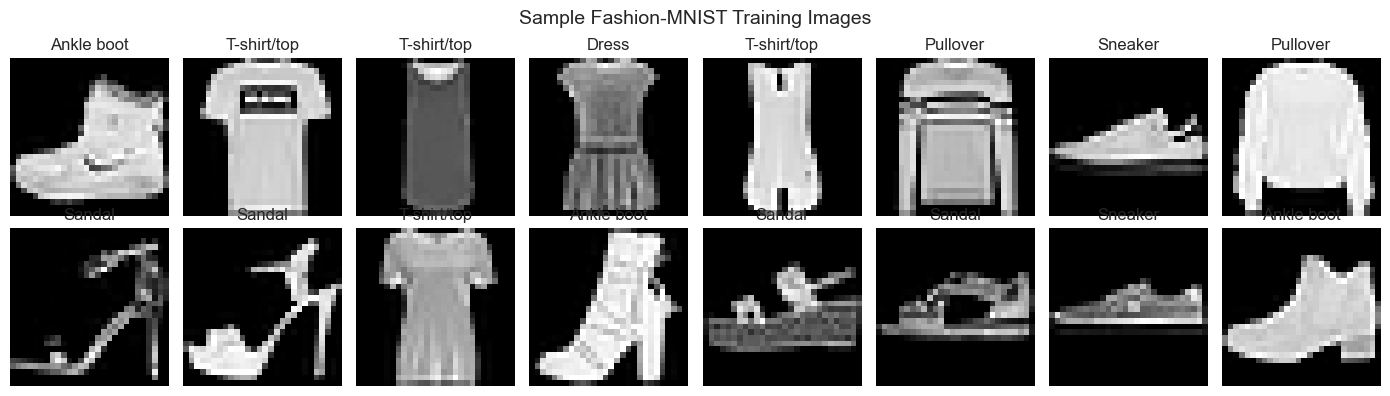

In [14]:
# Visualize some training samples
fig, axes = plt.subplots(2, 8, figsize=(14, 4))

for i in range(16):
    ax = axes[i // 8, i % 8]
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(f'{class_names[label]}')
    ax.axis('off')

plt.suptitle('Sample Fashion-MNIST Training Images', fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
# Verify batch shapes
sample_batch, sample_labels = next(iter(train_loader))

print("Batch Shape Verification")
print("=" * 60)
print(f"Images batch shape: {tuple(sample_batch.shape)} → (B, C, H, W)")
print(f"Labels batch shape: {tuple(sample_labels.shape)} → (B,)")
print(f"Pixel value range: [{sample_batch.min():.2f}, {sample_batch.max():.2f}]")
print()
print("Note: For unsupervised VAE training, we discard the labels.")

Batch Shape Verification
Images batch shape: (128, 1, 28, 28) → (B, C, H, W)
Labels batch shape: (128,) → (B,)
Pixel value range: [0.00, 1.00]

Note: For unsupervised VAE training, we discard the labels.


### Sanity Check: Untrained VAE Output

<span style="font-size: 15px;">

Before training, let's verify that all dimensions match up correctly by running a forward pass. The untrained VAE will produce **garbage output** (a gray, blobby mass), which is expected. As training progresses, this should refine into recognizable reconstructions.

</span>

In [17]:
# Initialize VAE with latent dimension 16
# (smaller latent space forces more compression and learning)
latent_dim = 16
vae = VAE(latent_dim=latent_dim)

# Check device
device = (
    'cuda' if torch.cuda.is_available()
    else 'mps' if torch.backends.mps.is_available()
    else 'cpu'
)
print(f"Using device: {device}")

vae = vae.to(device)

# Test forward pass with a batch
test_batch = sample_batch[:8].to(device)

print("\nDimension Verification")
print("=" * 60)

# Step through each component
with torch.no_grad():
    # Encoder output (before mu/logvar projection)
    h = vae.encoder(test_batch)
    print(f"Encoder output shape: {tuple(h.shape)} → (B, flattened_features)")
    
    # Mu and logvar
    mu, logvar = vae.encode(test_batch)
    print(f"μ shape: {tuple(mu.shape)} → (B, D_z={latent_dim})")
    print(f"log(σ²) shape: {tuple(logvar.shape)} → (B, D_z={latent_dim})")
    
    # Full forward pass
    x_hat, mu, logvar = vae(test_batch)
    print(f"Reconstruction shape: {tuple(x_hat.shape)} → (B, C, H, W)")

print("\n All dimensions match correctly!")

Using device: mps

Dimension Verification
Encoder output shape: (8, 512) → (B, flattened_features)
μ shape: (8, 16) → (B, D_z=16)
log(σ²) shape: (8, 16) → (B, D_z=16)
Reconstruction shape: (8, 1, 28, 28) → (B, C, H, W)

 All dimensions match correctly!


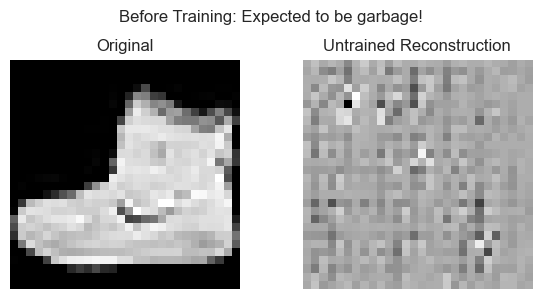

In [18]:
# Visualize untrained reconstruction
with torch.no_grad():
    sample_image = train_dataset[0][0].unsqueeze(0).to(device)  # Single image
    recon, _, _ = vae(sample_image)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))

axes[0].imshow(sample_image.cpu().squeeze(), cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

axes[1].imshow(recon.cpu().squeeze(), cmap='gray')
axes[1].set_title('Untrained Reconstruction')
axes[1].axis('off')

plt.suptitle('Before Training: Expected to be garbage!', fontsize=12)
plt.tight_layout()
plt.show()

### The Training Loop

<span style="font-size: 15px;">

The training loop is nearly identical to what we saw with the standard autoencoder. The key differences are:

1. **Loss function**: We use the VAE loss (reconstruction + KL divergence) instead of just MSE
2. **Forward pass outputs**: The VAE returns `(x_hat, mu, logvar)` for the loss computation
3. **Optimizer**: We use Adam instead of SGD (adaptive learning rate helps with the complex loss landscape)

**Training Loop Structure:**
```
for epoch in range(n_epochs):
    for batch_x, _ in train_loader:     # Discard labels (unsupervised)
        optimizer.zero_grad()            # Zero gradients
        x_hat, mu, logvar = vae(batch_x) # Forward pass
        loss = vae_loss(batch_x, x_hat, mu, logvar)  # VAE loss
        loss.backward()                  # Backward pass
        optimizer.step()                 # Update parameters
```

</span>

In [20]:
def show_image(tensor, size=128):
    """
    Convert a tensor to a displayable PIL image.
    
    Args:
        tensor: Image tensor of shape (1, H, W) or (H, W)
        size: Display size (images are small, so we upscale)
    
    Returns:
        PIL Image resized for display
    """
    # Ensure tensor is on CPU and 2D
    img = tensor.cpu().squeeze().detach()
    
    # Convert to PIL Image
    img_np = (img.numpy() * 255).astype(np.uint8)
    pil_img = Image.fromarray(img_np, mode='L')
    
    # Resize for better visibility
    pil_img = pil_img.resize((size, size), resample=Image.NEAREST)
    
    return pil_img


def train_vae(model, train_loader, n_epochs, learning_rate, device='cpu', 
              visualize_every=500, target_image=None):
    """
    Train a VAE with visualization of learning progress.
    
    Args:
        model: VAE model
        train_loader: DataLoader for training data
        n_epochs: Number of training epochs
        learning_rate: Learning rate for Adam optimizer
        device: Device to train on
        visualize_every: Show reconstruction every N batches
        target_image: Fixed image to visualize reconstruction progress
    
    Returns:
        losses: List of (total_loss, recon_loss, kl_loss) per epoch
    """
    model = model.to(device)
    
    # Adam optimizer (better than SGD for VAEs due to adaptive learning rate)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    losses = []
    
    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_recon = 0.0
        epoch_kl = 0.0
        running_loss = 0.0
        
        for i, (batch_x, _) in enumerate(train_loader):
            # Move to device
            batch_x = batch_x.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass: x -> (x_hat, mu, logvar)
            x_hat, mu, logvar = model(batch_x)
            
            # Compute VAE loss
            loss, recon_loss, kl_loss = vae_loss(batch_x, x_hat, mu, logvar)
            
            # Backward pass
            loss.backward()
            
            # Update parameters
            optimizer.step()
            
            # Accumulate losses
            epoch_loss += loss.item()
            epoch_recon += recon_loss.item()
            epoch_kl += kl_loss.item()
            running_loss += loss.item()
            
            # Visualize progress every N batches
            if (i + 1) % visualize_every == 0:
                clear_output(wait=True)
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{i+1}/{len(train_loader)}]")
                print(f"Loss: {running_loss / visualize_every:.3f}")
                running_loss = 0.0
                
                # Show reconstruction of target image
                if target_image is not None:
                    model.eval()
                    with torch.no_grad():
                        recon, _, _ = model(target_image)
                    
                    fig, axes = plt.subplots(1, 2, figsize=(4, 2))
                    axes[0].imshow(target_image.cpu().squeeze(), cmap='gray')
                    axes[0].set_title('Original')
                    axes[0].axis('off')
                    axes[1].imshow(recon.cpu().squeeze(), cmap='gray')
                    axes[1].set_title('Reconstruction')
                    axes[1].axis('off')
                    plt.tight_layout()
                    plt.show()
                    model.train()
        
        # Record epoch losses
        n_batches = len(train_loader)
        losses.append((
            epoch_loss / n_batches,
            epoch_recon / n_batches,
            epoch_kl / n_batches
        ))
        
        print(f"\nEpoch [{epoch+1}/{n_epochs}] Complete")
        print(f"  Total Loss: {losses[-1][0]:.3f}")
        print(f"  Recon Loss: {losses[-1][1]:.3f}")
        print(f"  KL Loss:    {losses[-1][2]:.3f}")
    
    print("\nTraining complete!")
    return losses

Epoch [10/10], Batch [400/469]
Loss: 29.514


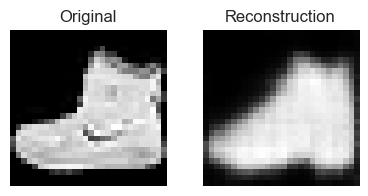


Epoch [10/10] Complete
  Total Loss: 29.517
  Recon Loss: 21.295
  KL Loss:    8.223

Training complete!


In [22]:
# Training hyperparameters
n_epochs = 10
learning_rate = 2e-4

# Select a target image to visualize reconstruction progress
# Using an ankle boot (class 9) as our reference
target_idx = 0
for i, (img, label) in enumerate(train_dataset):
    if label == 9:  # Ankle boot
        target_idx = i
        break

target_image = train_dataset[target_idx][0].unsqueeze(0).to(device)
print(f"Target image: {class_names[train_dataset[target_idx][1]]}")

# Initialize fresh VAE
vae = VAE(latent_dim=16).to(device)

print(f"\nTraining VAE on {device}")
print(f"Latent dimension: {latent_dim}")
print(f"Epochs: {n_epochs}")
print(f"Learning rate: {learning_rate}")
print("=" * 60)

# Train!
losses = train_vae(
    vae, train_loader, n_epochs=n_epochs, 
    learning_rate=learning_rate, device=device,
    visualize_every=200, target_image=target_image
)

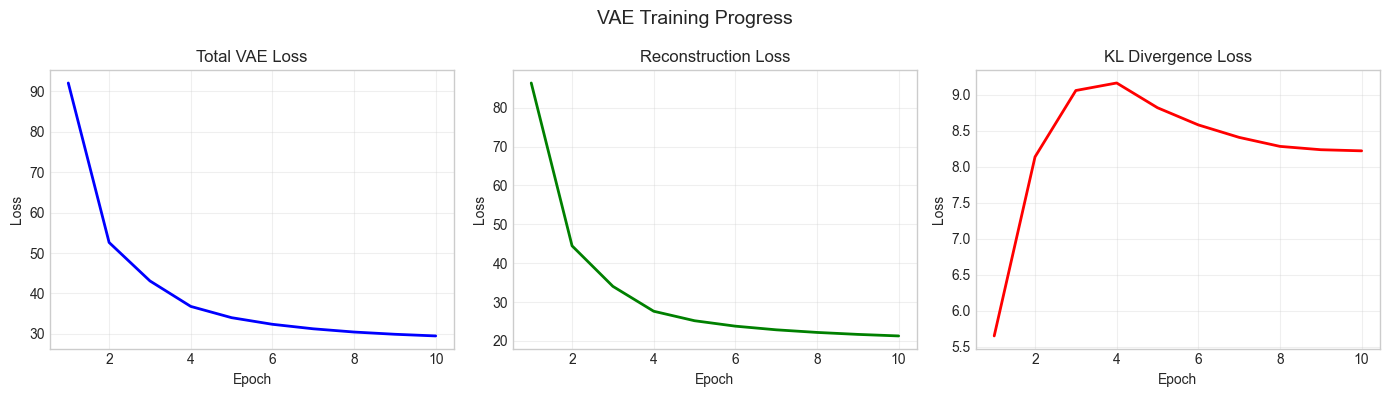

In [23]:
# Plot training curves
total_losses, recon_losses, kl_losses = zip(*losses)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

epochs = range(1, n_epochs + 1)

axes[0].plot(epochs, total_losses, 'b-', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Total VAE Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, recon_losses, 'g-', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Reconstruction Loss')
axes[1].grid(True, alpha=0.3)

axes[2].plot(epochs, kl_losses, 'r-', linewidth=2)
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss')
axes[2].set_title('KL Divergence Loss')
axes[2].grid(True, alpha=0.3)

plt.suptitle('VAE Training Progress', fontsize=14)
plt.tight_layout()
plt.show()

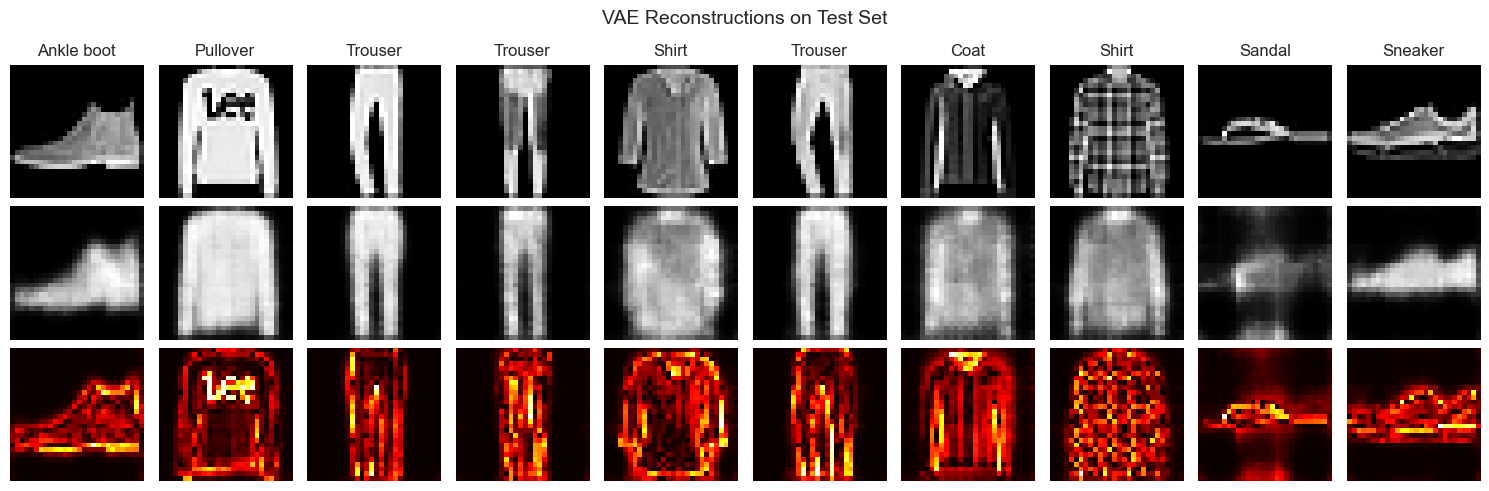

In [24]:
# Visualize reconstructions on test set
vae.eval()

n_show = 10
test_images, test_labels = next(iter(test_loader))
test_images = test_images[:n_show].to(device)

with torch.no_grad():
    recons, _, _ = vae(test_images)

fig, axes = plt.subplots(3, n_show, figsize=(15, 5))

for i in range(n_show):
    # Original
    axes[0, i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0, i].set_title(f'{class_names[test_labels[i]]}')
    axes[0, i].axis('off')
    
    # Reconstruction
    axes[1, i].imshow(recons[i].cpu().squeeze(), cmap='gray')
    axes[1, i].axis('off')
    
    # Difference
    diff = torch.abs(test_images[i] - recons[i])
    axes[2, i].imshow(diff.cpu().squeeze(), cmap='hot')
    axes[2, i].axis('off')

axes[0, 0].set_ylabel('Original', fontsize=12)
axes[1, 0].set_ylabel('Reconstructed', fontsize=12)
axes[2, 0].set_ylabel('|Error|', fontsize=12)

plt.suptitle('VAE Reconstructions on Test Set', fontsize=14)
plt.tight_layout()
plt.show()

## Exploring the Latent Space

<span style="font-size: 15px;">

Now that we have a trained VAE, we can explore its **latent space**—the compressed representation the model has learned. This is where the magic of generative models becomes apparent.

**Key Properties of a Well-Trained VAE Latent Space:**

1. **Smoothness**: Nearby points in latent space produce similar images
2. **Continuity**: We can smoothly interpolate between any two points
3. **Structure**: Similar images cluster together (boots near boots, shirts near shirts)
4. **Generative**: Random samples from $\mathcal{N}(0, I)$ produce realistic images

We'll explore:
1. **Generation**: Sampling random latent vectors and decoding them
2. **Visualization**: Using dimensionality reduction to visualize the 16D latent space
3. **Interpolation**: Smoothly transitioning between two images
4. **Attribute Vectors**: Adding/removing "bootness" or other features

</span>

### Generating New Samples

<span style="font-size: 15px;">

The most basic capability of a trained generative model is to **generate new data points**. For a VAE, this is simple:

1. Sample a random latent vector: $z \sim \mathcal{N}(0, I)$
2. Pass it through the decoder: $\hat{x} = D_\theta(z)$

Each random vector produces a different image that should look like something from our training distribution (clothing items).

</span>

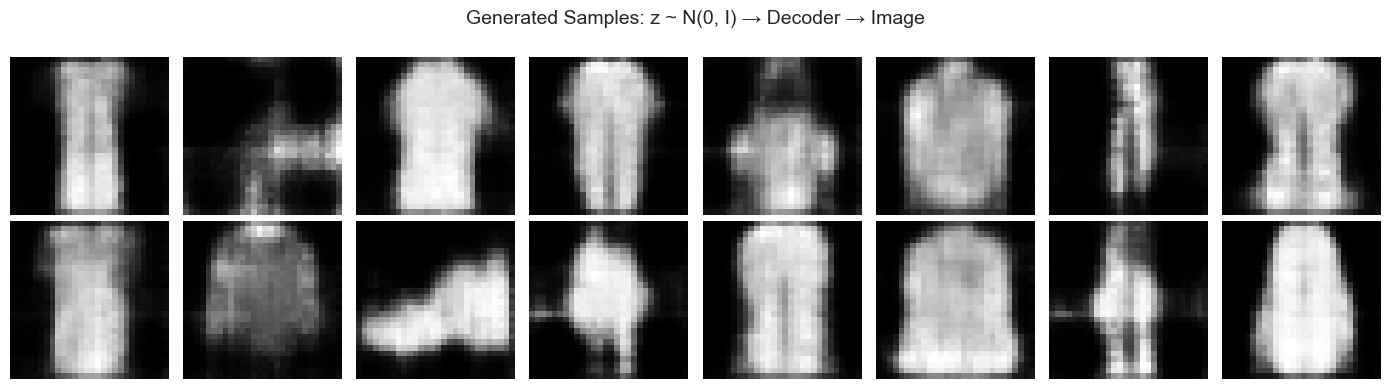

Each sample comes from a different random latent vector.
Latent vectors shape: (16, 16)


In [25]:
def generate_samples(model, n_samples, latent_dim, device='cpu'):
    """
    Generate new images by sampling from the latent space.
    
    z ~ N(0, I)  ->  Decoder  ->  x_generated
    """
    model.eval()
    
    with torch.no_grad():
        # Sample from standard normal
        z = torch.randn(n_samples, latent_dim).to(device)
        
        # Decode to images
        generated = model.decode(z)
    
    return generated, z


# Generate samples
n_samples = 16
generated_images, latent_vectors = generate_samples(vae, n_samples, latent_dim, device)

# Visualize
fig, axes = plt.subplots(2, 8, figsize=(14, 4))

for i in range(n_samples):
    ax = axes[i // 8, i % 8]
    ax.imshow(generated_images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')

plt.suptitle('Generated Samples: z ~ N(0, I) → Decoder → Image', fontsize=14)
plt.tight_layout()
plt.show()

print("Each sample comes from a different random latent vector.")
print(f"Latent vectors shape: {tuple(latent_vectors.shape)}")

Generating multiple batches to see variety in outputs:


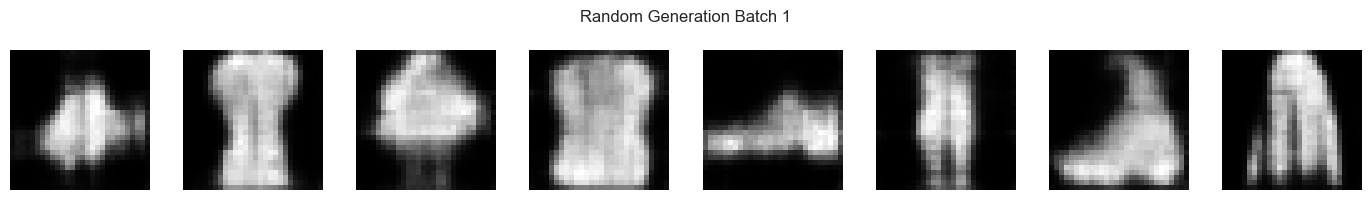

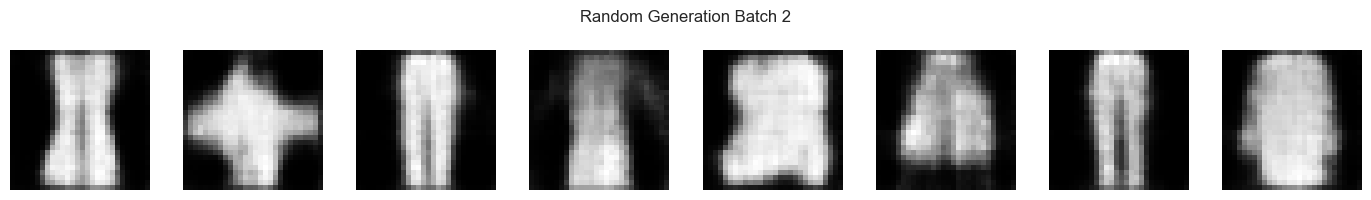

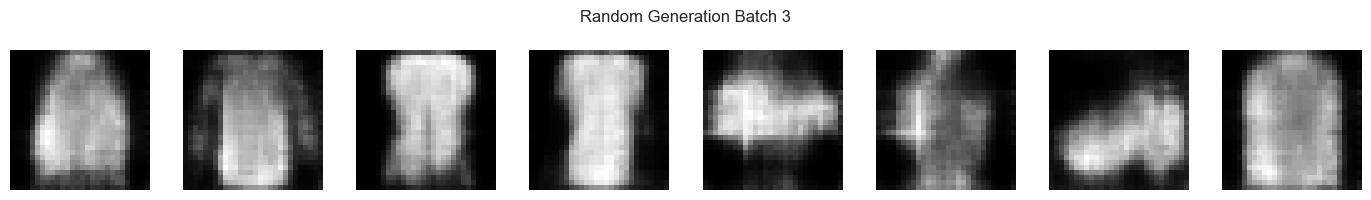

In [26]:
# Generate more samples to see variety
print("Generating multiple batches to see variety in outputs:")

for batch_num in range(3):
    generated, _ = generate_samples(vae, 8, latent_dim, device)
    
    fig, axes = plt.subplots(1, 8, figsize=(14, 2))
    for i in range(8):
        axes[i].imshow(generated[i].cpu().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.suptitle(f'Random Generation Batch {batch_num + 1}', fontsize=12)
    plt.tight_layout()
    plt.show()

### Visualizing the Latent Space

<span style="font-size: 15px;">

To understand what the VAE has learned, we can encode many images into latent space and visualize them. Since our latent space is 16-dimensional, we need **dimensionality reduction** (e.g., PCA, t-SNE) to project it to 2D for visualization.

If the VAE has learned meaningful representations:
- Similar items should cluster together
- Different classes should be separated
- The space should be continuous (no large gaps)

</span>

In [27]:
def get_latents(model, images, device='cpu'):
    """
    Encode images to latent vectors (using mean, not sampled).
    
    For visualization, we use μ directly (deterministic) rather than sampling.
    """
    model.eval()
    with torch.no_grad():
        images = images.to(device)
        mu, logvar = model.encode(images)
    return mu.cpu()


# Sample images from the dataset
n_samples = 1000
indices = torch.randperm(len(train_dataset))[:n_samples]

sample_images = []
sample_labels = []

for idx in indices:
    img, label = train_dataset[idx]
    sample_images.append(img)
    sample_labels.append(label)

sample_images = torch.stack(sample_images)
sample_labels = torch.tensor(sample_labels)

print(f"Sampled {n_samples} images")
print(f"Images shape: {tuple(sample_images.shape)}")

# Encode all samples
latent_vectors = get_latents(vae, sample_images, device)
print(f"Latent vectors shape: {tuple(latent_vectors.shape)}")

Sampled 1000 images
Images shape: (1000, 1, 28, 28)
Latent vectors shape: (1000, 16)


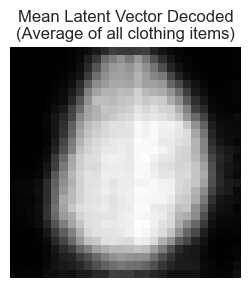

The mean image is a blend of all classes - a generic 'clothing' shape.


In [28]:
# Compute and visualize the "mean image" in latent space
mean_latent = latent_vectors.mean(dim=0, keepdim=True)

with torch.no_grad():
    mean_image = vae.decode(mean_latent.to(device))

plt.figure(figsize=(3, 3))
plt.imshow(mean_image.cpu().squeeze(), cmap='gray')
plt.title('Mean Latent Vector Decoded\n(Average of all clothing items)')
plt.axis('off')
plt.show()

print("The mean image is a blend of all classes - a generic 'clothing' shape.")

Applying PCA to reduce 16D latent space to 2D...
Applying t-SNE to reduce 16D latent space to 2D...


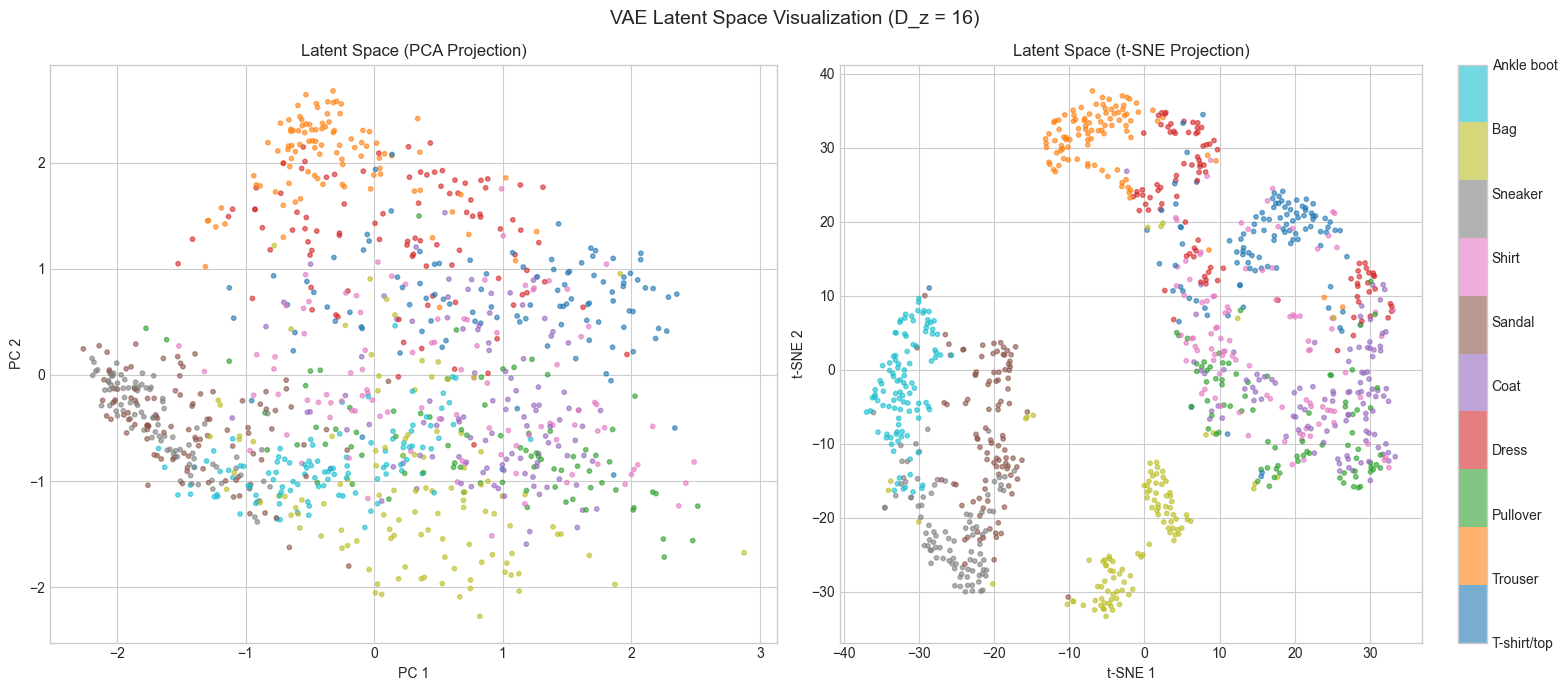


Observe: Similar items cluster together!
- Footwear (sandals, sneakers, boots) forms a region
- Tops (shirts, t-shirts, pullovers) form another region
- The VAE has learned meaningful representations without labels!


In [29]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Use PCA for visualization (fastest, most direct)
print("Applying PCA to reduce 16D latent space to 2D...")
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_vectors.numpy())

# Also try t-SNE for comparison
print("Applying t-SNE to reduce 16D latent space to 2D...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
latent_2d_tsne = tsne.fit_transform(latent_vectors.numpy())

# Plot both
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# PCA plot
scatter1 = axes[0].scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1],
                          c=sample_labels.numpy(), cmap='tab10', alpha=0.6, s=10)
axes[0].set_xlabel('PC 1')
axes[0].set_ylabel('PC 2')
axes[0].set_title('Latent Space (PCA Projection)')

# t-SNE plot
scatter2 = axes[1].scatter(latent_2d_tsne[:, 0], latent_2d_tsne[:, 1],
                          c=sample_labels.numpy(), cmap='tab10', alpha=0.6, s=10)
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].set_title('Latent Space (t-SNE Projection)')

# Add colorbars with class names
cbar = plt.colorbar(scatter2, ax=axes[1], ticks=range(10))
cbar.ax.set_yticklabels(class_names)

plt.suptitle('VAE Latent Space Visualization (D_z = 16)', fontsize=14)
plt.tight_layout()
plt.show()

print("\nObserve: Similar items cluster together!")
print("- Footwear (sandals, sneakers, boots) forms a region")
print("- Tops (shirts, t-shirts, pullovers) form another region")
print("- The VAE has learned meaningful representations without labels!")

### Latent Space Interpolation

<span style="font-size: 15px;">

One of the most powerful properties of a well-structured latent space is **interpolation**: we can smoothly transition between any two images by interpolating their latent vectors.

**Linear Interpolation:**

Given two latent vectors $z_1$ and $z_2$, and a parameter $t \in [0, 1]$:

$$
z_{\text{interp}}(t) = (1 - t) \cdot z_1 + t \cdot z_2
$$

- At $t = 0$: We get $z_1$ (first image)
- At $t = 1$: We get $z_2$ (second image)
- At $t = 0.5$: We get a blend of both

This allows us to see smooth transitions between, e.g., a sneaker and a sandal.

</span>

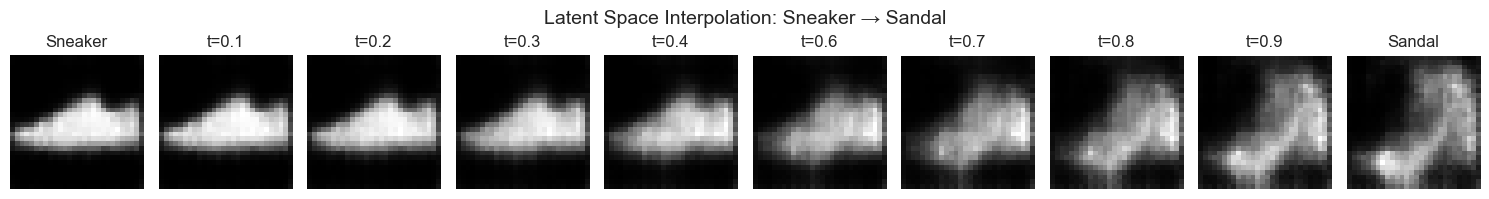

Observe the smooth transition:
- The flat sneaker gradually develops a heel
- The top opens up as we approach the sandal
- Intermediate images are plausible shoe shapes!


In [30]:
def linear_interpolation(z1, z2, t):
    """
    Linear interpolation between two latent vectors.
    
    z_interp = (1 - t) * z1 + t * z2
    
    Args:
        z1, z2: Latent vectors (1, D_z)
        t: Interpolation parameter in [0, 1]
    
    Returns:
        Interpolated latent vector
    """
    return (1 - t) * z1 + t * z2


def interpolate_images(model, img1, img2, n_steps=10, device='cpu'):
    """
    Interpolate between two images in latent space.
    """
    model.eval()
    
    with torch.no_grad():
        # Encode both images to latent space
        mu1, _ = model.encode(img1.unsqueeze(0).to(device))
        mu2, _ = model.encode(img2.unsqueeze(0).to(device))
        
        # Interpolate
        interpolations = []
        for t in np.linspace(0, 1, n_steps):
            z_interp = linear_interpolation(mu1, mu2, t)
            img_interp = model.decode(z_interp)
            interpolations.append(img_interp.cpu().squeeze())
    
    return interpolations, mu1.cpu(), mu2.cpu()


# Find a sneaker and a sandal
sneaker_img = None
sandal_img = None

for img, label in train_dataset:
    if label == 7 and sneaker_img is None:  # Sneaker
        sneaker_img = img
    if label == 5 and sandal_img is None:  # Sandal
        sandal_img = img
    if sneaker_img is not None and sandal_img is not None:
        break

# Interpolate
interpolations, z_sneaker, z_sandal = interpolate_images(
    vae, sneaker_img, sandal_img, n_steps=10, device=device
)

# Visualize
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i, img in enumerate(interpolations):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')
    if i == 0:
        axes[i].set_title('Sneaker')
    elif i == 9:
        axes[i].set_title('Sandal')
    else:
        axes[i].set_title(f't={i/9:.1f}')

plt.suptitle('Latent Space Interpolation: Sneaker → Sandal', fontsize=14)
plt.tight_layout()
plt.show()

print("Observe the smooth transition:")
print("- The flat sneaker gradually develops a heel")
print("- The top opens up as we approach the sandal")
print("- Intermediate images are plausible shoe shapes!")

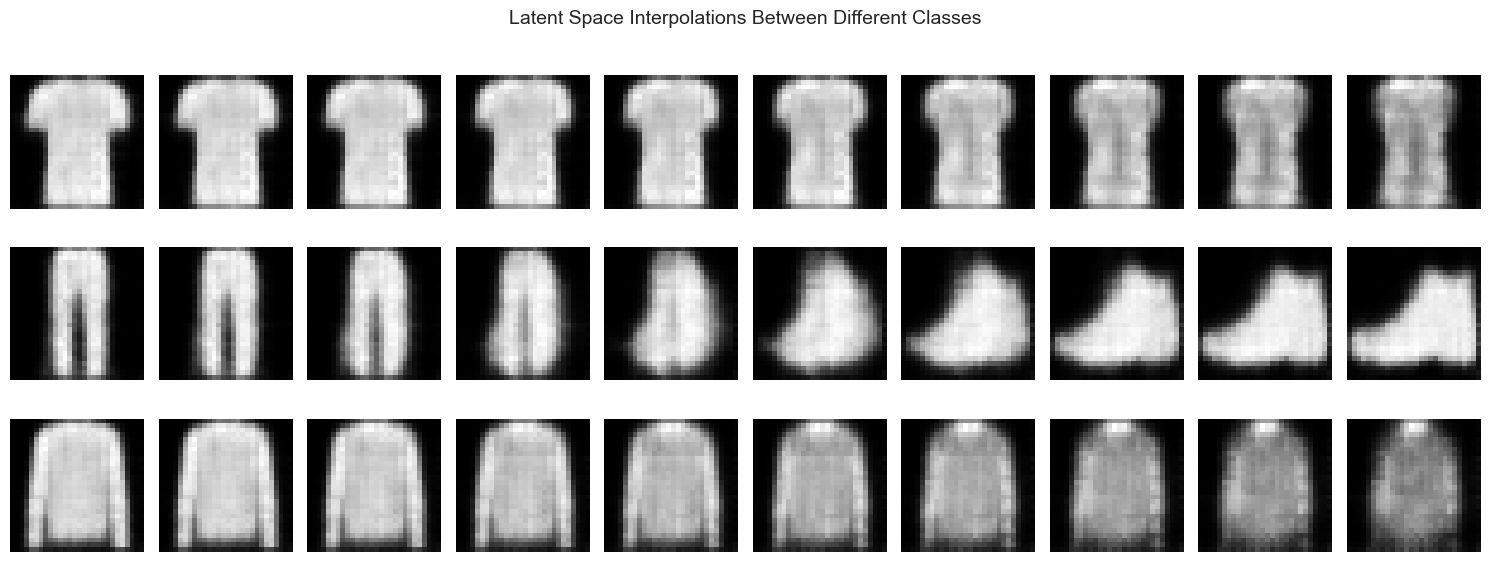

In [31]:
# More interpolation examples
pairs = [
    (0, 3, 'T-shirt', 'Dress'),      # T-shirt -> Dress
    (1, 9, 'Trouser', 'Ankle boot'), # Trouser -> Boot
    (2, 4, 'Pullover', 'Coat'),      # Pullover -> Coat
]

fig, axes = plt.subplots(len(pairs), 10, figsize=(15, 2 * len(pairs)))

for row, (label1, label2, name1, name2) in enumerate(pairs):
    # Find images
    img1, img2 = None, None
    for img, label in train_dataset:
        if label == label1 and img1 is None:
            img1 = img
        if label == label2 and img2 is None:
            img2 = img
        if img1 is not None and img2 is not None:
            break
    
    # Interpolate
    interps, _, _ = interpolate_images(vae, img1, img2, n_steps=10, device=device)
    
    for col, img in enumerate(interps):
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
    
    axes[row, 0].set_ylabel(f'{name1}→{name2}', fontsize=10)

plt.suptitle('Latent Space Interpolations Between Different Classes', fontsize=14)
plt.tight_layout()
plt.show()

### Attribute Vectors

<span style="font-size: 15px;">

An even more powerful technique is computing **attribute vectors**: directions in latent space that correspond to specific features.

**Computing an Attribute Vector:**

To find the "bootness" direction:
1. Encode all boot images → compute their mean latent vector $\bar{z}_{\text{boot}}$
2. Encode all non-boot images → compute their mean $\bar{z}_{\text{not-boot}}$
3. The attribute vector is the difference:
   $$v_{\text{boot}} = \bar{z}_{\text{boot}} - \bar{z}_{\text{not-boot}}$$

**Using the Attribute Vector:**

We can add or subtract "bootness" from any image:
$$z_{\text{modified}} = z_{\text{original}} + \alpha \cdot v_{\text{boot}}$$

- $\alpha > 0$: Add bootness (make more boot-like)
- $\alpha < 0$: Remove bootness (make less boot-like)

</span>

Boot attribute vector shape: (1, 16)


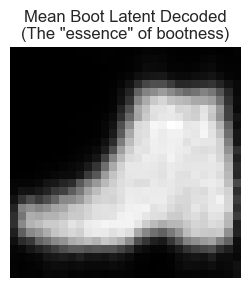

In [32]:
def compute_attribute_vector(model, dataset, target_class, device='cpu', n_samples=500):
    """
    Compute an attribute vector for a specific class.
    
    attribute_vector = mean(target_class) - mean(other_classes)
    """
    model.eval()
    
    target_latents = []
    other_latents = []
    
    with torch.no_grad():
        for img, label in dataset:
            img = img.unsqueeze(0).to(device)
            mu, _ = model.encode(img)
            
            if label == target_class:
                target_latents.append(mu.cpu())
            else:
                other_latents.append(mu.cpu())
            
            # Limit samples for speed
            if len(target_latents) >= n_samples and len(other_latents) >= n_samples:
                break
    
    # Compute means
    mean_target = torch.cat(target_latents, dim=0).mean(dim=0, keepdim=True)
    mean_other = torch.cat(other_latents, dim=0).mean(dim=0, keepdim=True)
    
    # Attribute vector = target - other
    attribute_vector = mean_target - mean_other
    
    return attribute_vector, mean_target


# Compute "boot" attribute vector (class 9 = Ankle boot)
boot_vector, mean_boot = compute_attribute_vector(vae, train_dataset, target_class=9, device=device)

print(f"Boot attribute vector shape: {tuple(boot_vector.shape)}")

# Visualize what the boot vector looks like when decoded
with torch.no_grad():
    boot_image = vae.decode(mean_boot.to(device))

plt.figure(figsize=(3, 3))
plt.imshow(boot_image.cpu().squeeze(), cmap='gray')
plt.title('Mean Boot Latent Decoded\n(The "essence" of bootness)')
plt.axis('off')
plt.show()

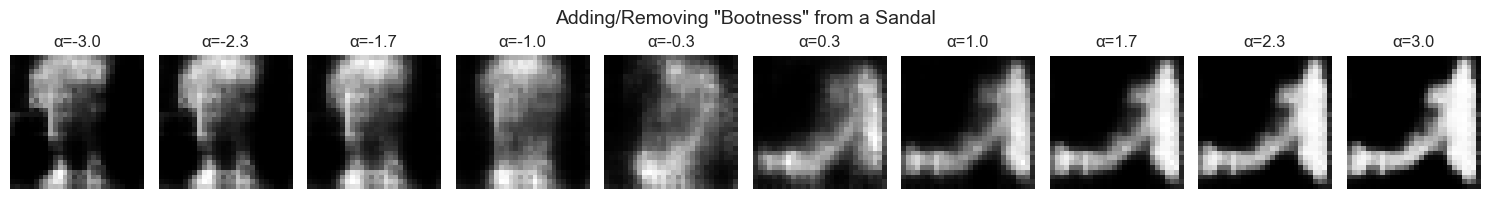

Observations:
- α < 0 (left): Removing bootness → looks more like pants/dress
- α = 0 (middle): Original sandal
- α > 0 (right): Adding bootness → top closes, becomes more boot-like


In [33]:
def apply_attribute_vector(model, image, attribute_vector, scales, device='cpu'):
    """
    Apply an attribute vector to an image at different scales.
    
    z_modified = z_original + scale * attribute_vector
    """
    model.eval()
    
    results = []
    
    with torch.no_grad():
        # Encode original image
        mu, _ = model.encode(image.unsqueeze(0).to(device))
        
        for scale in scales:
            # Apply attribute vector
            z_modified = mu + scale * attribute_vector.to(device)
            
            # Decode
            img_modified = model.decode(z_modified)
            results.append(img_modified.cpu().squeeze())
    
    return results


# Apply boot vector to a sandal
sandal_img = None
for img, label in train_dataset:
    if label == 5:  # Sandal
        sandal_img = img
        break

scales = np.linspace(-3, 3, 10)
modified_images = apply_attribute_vector(vae, sandal_img, boot_vector, scales, device)

# Visualize
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i, (img, scale) in enumerate(zip(modified_images, scales)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'α={scale:.1f}')
    axes[i].axis('off')

plt.suptitle('Adding/Removing "Bootness" from a Sandal', fontsize=14)
plt.tight_layout()
plt.show()

print("Observations:")
print("- α < 0 (left): Removing bootness → looks more like pants/dress")
print("- α = 0 (middle): Original sandal")
print("- α > 0 (right): Adding bootness → top closes, becomes more boot-like")

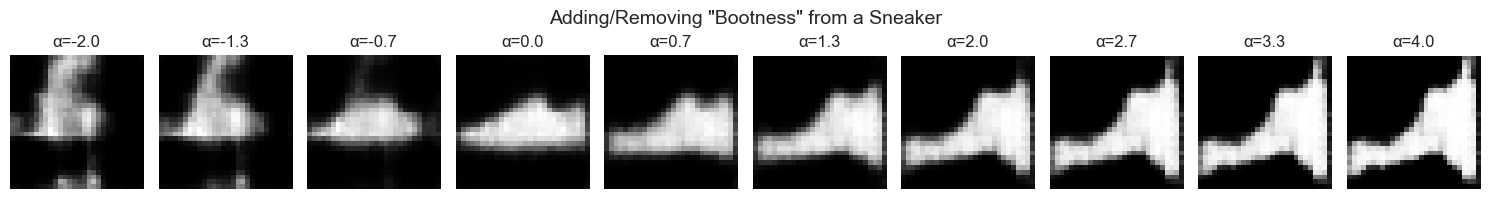

Observations:
- α < 0: Removing bootness from sneaker → looks like dress/shirt!
- α > 0: Adding bootness → sneaker becomes taller, more boot-like


In [34]:
# Apply boot vector to a sneaker
sneaker_img = None
for img, label in train_dataset:
    if label == 7:  # Sneaker
        sneaker_img = img
        break

scales = np.linspace(-2, 4, 10)
modified_images = apply_attribute_vector(vae, sneaker_img, boot_vector, scales, device)

# Visualize
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i, (img, scale) in enumerate(zip(modified_images, scales)):
    axes[i].imshow(img, cmap='gray')
    axes[i].set_title(f'α={scale:.1f}')
    axes[i].axis('off')

plt.suptitle('Adding/Removing "Bootness" from a Sneaker', fontsize=14)
plt.tight_layout()
plt.show()

print("Observations:")
print("- α < 0: Removing bootness from sneaker → looks like dress/shirt!")
print("- α > 0: Adding bootness → sneaker becomes taller, more boot-like")

### Summary: What We've Learned About Latent Space

<span style="font-size: 15px;">

**Key Takeaways:**

1. **Generation**: We can generate new, realistic images by sampling $z \sim \mathcal{N}(0, I)$ and decoding.

2. **Structure**: The VAE learns a structured latent space where:
   - Similar items cluster together (boots with boots, shirts with shirts)
   - The space is continuous—no "holes" like in standard autoencoders

3. **Interpolation**: We can smoothly transition between any two images:
   $$z_{\text{interp}} = (1-t) \cdot z_1 + t \cdot z_2$$

4. **Attribute Vectors**: We can find directions in latent space that correspond to semantic features:
   $$v_{\text{attribute}} = \bar{z}_{\text{with\_attribute}} - \bar{z}_{\text{without\_attribute}}$$
   
   Then add/remove attributes:
   $$z_{\text{modified}} = z_{\text{original}} + \alpha \cdot v_{\text{attribute}}$$

**The Power of Latent Space:**

These operations work because the VAE has learned a **disentangled**, **smooth** representation where:
- Arithmetic operations on vectors translate to semantic operations on images
- The KL divergence term ensures the space is well-organized
- Nearby points produce similar images

This is why VAEs (and their successors like Stable Diffusion's VAE component) are so powerful for generative modeling!

</span>